# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
auto_df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(auto_df.head(10))
print(auto_df.info())
print('Количество дубликатов:', sum(auto_df.duplicated()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
print('Количество пропусков', 
      auto_df.isna().mean())

Количество пропусков DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


In [5]:
auto_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Выводы**

   1) В столбце `Цена` минимальная цена 0.
   
   2) В столбце `RegistrationYear` есть некорректные значения года регистрации.
   
   3) В столбце `Power` есть некорректные значения мощности двигателя.
   
   4) В столбце `Kilometer` более 50% с пробегом 150000 при этом ни боьше ни меньше, скорее всего это какое-то ограничение в заявке, но согласитесь разница между 150000 и 300000 довольно существена и даолжна влиять на стоимость.
   
   5) В столбце RegistrationMonth отсутсвует месяц регистрации.

Далее пройдемся по признакам, значимых для нашей модели:

   - VehicleType. Тип машины определяет ее функционал и возможности. Чем их больше машины, тем выше цена.
    
   - RegistrationYear. Год регистрации определяет "свежесть" машины. Соответвенно, чем больше возраст, тем меньше цена.
    
   - Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
    
   - Power. Мощность в лошадиных силах напрямую влияют на цену.
    
   - Model. В совокупности с типом машины и брендом може влиять на популярность у покупателей.
    
   - Kilometer.  Чем больше пробег, тем меньше ее надежность и соответсвенно цена.
    
   - FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
    
   - Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
    
   - NotRepaired. Если машина побывала в ДТП, то ее констукция уже видиизменена, следовательно надежность и качество ниже, как и цена.

In [6]:
# На основе вывода создадим новый фрейм
filtred_auto_df = auto_df[['VehicleType', 
                         'RegistrationYear',
                         'Gearbox', 
                         'Power',
                         'Model',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'Price']]
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   NotRepaired       283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
filtred_auto_df.duplicated().sum()

45040

In [8]:
filtred_auto_df = filtred_auto_df.drop_duplicates()
filtred_auto_df.duplicated().sum()

0

Типы данных в столбцах верные, однако мы видим, что пропуском довольно много, следовательно:

1) В столбце `VehicleType` постараемся восстановить данные на основе популярного показателя из столбца `Brand`

2) В столбце `RegistrationYear` скоректируем данные на основе реальных значений в машинах в сравнении с другими (пробег, марка, модель)

3) В столбце `Gearbox` везде заполнил как manual - ручная

4) В столбце `Power` скоректируем данные на основе реальных значений по аналогии с `RegistrationYear`

5) В столбце `FuelType` по анлогии с`VehicleType`

6) В столбце `NotRepaired` для всех NaN И пропусков установим значение yes

7) В столбце `Model` для всех NaN установим значение 'unknown'.

Но прежде всего отработаем данные п оцелевому признаку `Price`

<AxesSubplot:>

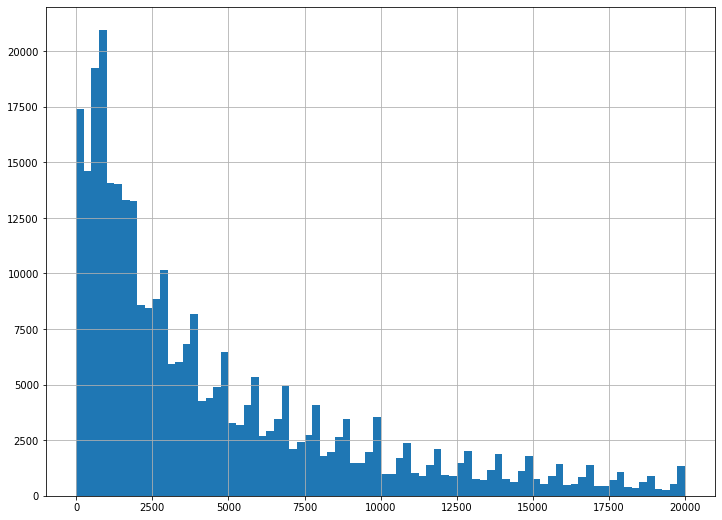

In [9]:
# Построим гистограмму
filtred_auto_df['Price'].hist(bins=80, figsize=(12,9))

In [10]:
filtred_auto_df['Price'].value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: Price, Length: 3731, dtype: int64

10772 значений с 0, удалим их и посмотрим как это повлияет на распределение на гистограмме

count    300425.000000
mean       4619.921098
std        4565.205287
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64

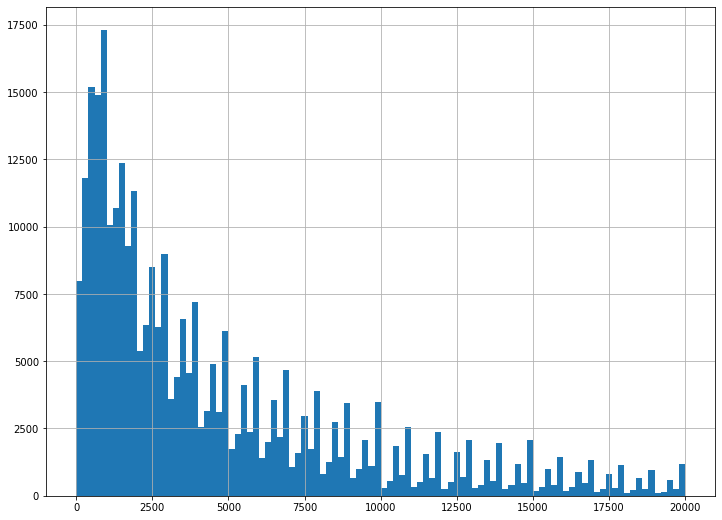

In [11]:
filtred_auto_df = filtred_auto_df.query('Price > 0')
filtred_auto_df['Price'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Price'].describe()

In [12]:
filtred_auto_df['Price'].quantile([0.2, 0.88])

0.20      990.0
0.88    10750.0
Name: Price, dtype: float64

Стоимость 990 евро примерно равно 68000 рублей (в целом за такую сумму можно купить машину). Выбор 88% квантиля обоснован выбросами после 10000 евро и в целом на гистограмме видно, что значения после не особо отличаются.

In [13]:
filtred_auto_df = filtred_auto_df.query('990 <= Price <= 10500')
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204267 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       185868 non-null  object
 1   RegistrationYear  204267 non-null  int64 
 2   Gearbox           195894 non-null  object
 3   Power             204267 non-null  int64 
 4   Model             194352 non-null  object
 5   Kilometer         204267 non-null  int64 
 6   FuelType          188344 non-null  object
 7   Brand             204267 non-null  object
 8   NotRepaired       167863 non-null  object
 9   Price             204267 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 17.1+ MB


Далее перейдем в столбцу 'RegistrationYear'

count    204267.000000
mean       2003.978322
std          58.632683
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

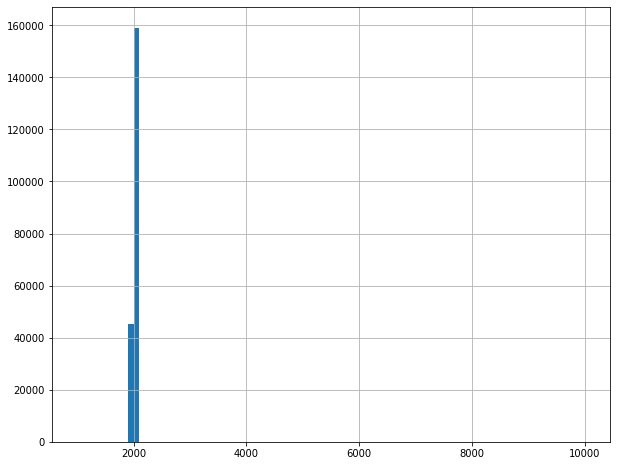

In [14]:
filtred_auto_df['RegistrationYear'].hist(bins=90, figsize=(10,8))
filtred_auto_df['RegistrationYear'].describe()

In [15]:
car_date_max = pd.to_datetime(auto_df['DateCrawled'])
car_date_max.max()

Timestamp('2016-04-07 14:36:58')

In [16]:
car_date_min = pd.to_datetime(auto_df['RegistrationYear'])
car_date_min.min()

Timestamp('1970-01-01 00:00:00.000001')

count    194020.000000
mean       2002.891434
std           5.903556
min        1971.000000
25%        2000.000000
50%        2003.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

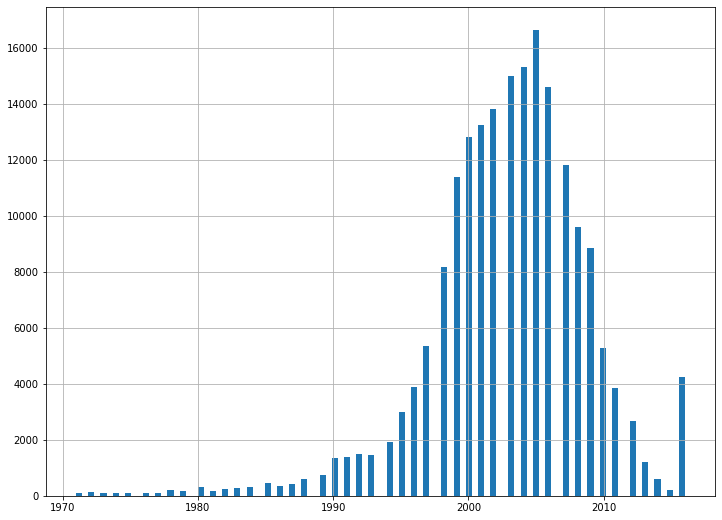

In [17]:
filtred_auto_df = filtred_auto_df.query('1970 < RegistrationYear < 2017')
filtred_auto_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_auto_df['RegistrationYear'].describe()

Даты регистрации после 2016 года некорректны, как и до 1970. Отсечем ненужные года и построим график, в целом у нас вырисовывается хороший график.

Далее зайемемся заменов данных в столбцах `Gearbox, NotRepaired и Model`

In [18]:

filtred_auto_df.fillna({'Gearbox':'manual', 'NotRepaired':'yes', 'Model':'unknown'},
                          inplace=True)
filtred_auto_df.isna().mean()

VehicleType         0.045428
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.062524
Brand               0.000000
NotRepaired         0.000000
Price               0.000000
dtype: float64

Супер, осталось разобраться со столбцами `VehicleType и FuelType `

In [19]:
# Оценим кол-во пропущенных значений относительно всех значений в столбце VehicleType, 
# в целом мы бы могли просто закинуть из в другие или в самый популярный тип седан,
# но это было бы не качественно, так что идем дальше
display(filtred_auto_df['VehicleType'].value_counts())
display(filtred_auto_df['VehicleType'].isna().sum())

sedan          53800
small          43058
wagon          38566
bus            19914
convertible    12706
coupe           8966
suv             6169
other           2027
Name: VehicleType, dtype: int64

8814

In [20]:
#Построим сводную таблицу для того чтобы наглядно увидеть у каких марок, какие модели, какой кузов и сколько их.
vehicle_type_pvt = filtred_auto_df.pivot_table(index=['VehicleType'], 
                                                    columns=['Brand'],
                                                    values=['Price'],
                                                    aggfunc=['count'])
display(vehicle_type_pvt)

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      5.0      98.0    269.0   994.0   33.0   
convertible      119.0   885.0   1915.0       8.0    170.0    93.0    NaN   
coupe            174.0   658.0   2036.0      49.0     30.0   102.0    NaN   
other              5.0    67.0    139.0      21.0      6.0    75.0    5.0   
sedan            571.0  6253.0  10324.0     166.0    158.0   448.0   88.0   
small            177.0   750.0    251.0     505.0      8.0  1105.0  190.0   
suv                NaN    14.0    315.0     231.0     13.0    10.0  142.0   
wagon            305.0  6262.0   4726.0      82.0    174.0   385.0  221.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           18.0     19.0   623.0  ...   466.0   183.0     1.0   
convertible    NaN     15.0   291.0  ...     NaN     2.0   988.0   
coupe          1.0      NaN   119.0  ...    48.0     5.0   284.0   
other          3.0      5.0   123.0  ...    32.0    19.0     7.0   
sedan         44.0     31.0   541.0  ...  1142.0   654.0    24.0   
small        139.0    245.0  2842.0  ...  1874.0   856.0  2687.0   
suv            1.0     29.0    17.0  ...     3.0    22.0     NaN   
wagon         19.0     14.0   232.0  ...   183.0  1807.0     1.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  145.0   12.0   19.0   373.0     NaN     6123.0     NaN  
convertible          180.0    1.0   28.0    55.0    28.0     1822.0    36.0  
coupe                 74.0    3.0    NaN   146.0     2.0      705.0    42.0  
other                131.0    4.0   10.0    13.0     5.0      503.0     2.0  
sedan                231.0   94.0   99.0   696.0    91.0    11009.0   410.0  
small                136.0   52.0  610.0  1254.0    28.0     9352.0     7.0  
suv                  223.0   42.0  586.0   318.0     NaN      367.0    65.0  
wagon                 90.0  175.0   53.0   430.0    40.0     7532.0  1158.0  

[8 rows x 40 columns]

In [21]:
vehicle_type_pvt = vehicle_type_pvt['count']['Price']
vehicle_type_pvt

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,98.0,269.0,994.0,33.0,18.0,19.0,623.0,...,466.0,183.0,1.0,145.0,12.0,19.0,373.0,NaN,6123.0,NaN
convertible,119.0,885.0,1915.0,8.0,170.0,93.0,NaN,NaN,15.0,291.0,...,NaN,2.0,988.0,180.0,1.0,28.0,55.0,28.0,1822.0,36.0
coupe,174.0,658.0,2036.0,49.0,30.0,102.0,NaN,1.0,NaN,119.0,...,48.0,5.0,284.0,74.0,3.0,NaN,146.0,2.0,705.0,42.0
other,5.0,67.0,139.0,21.0,6.0,75.0,5.0,3.0,5.0,123.0,...,32.0,19.0,7.0,131.0,4.0,10.0,13.0,5.0,503.0,2.0
sedan,571.0,6253.0,10324.0,166.0,158.0,448.0,88.0,44.0,31.0,541.0,...,1142.0,654.0,24.0,231.0,94.0,99.0,696.0,91.0,11009.0,410.0
small,177.0,750.0,251.0,505.0,8.0,1105.0,190.0,139.0,245.0,2842.0,...,1874.0,856.0,2687.0,136.0,52.0,610.0,1254.0,28.0,9352.0,7.0
suv,NaN,14.0,315.0,231.0,13.0,10.0,142.0,1.0,29.0,17.0,...,3.0,22.0,NaN,223.0,42.0,586.0,318.0,NaN,367.0,65.0
wagon,305.0,6262.0,4726.0,82.0,174.0,385.0,221.0,19.0,14.0,232.0,...,183.0,1807.0,1.0,90.0,175.0,53.0,430.0,40.0,7532.0,1158.0


In [22]:
# Заполним пустые ячейки 0
filtred_auto_df.fillna({'VehicleType':0},inplace=True)
# Напишем функцию которая будет в пропущенные значения вставлять тот тип кузова, который 
# чаще всего распрастранен для конкретной марки марки авто
def fillna_by_brand(row, row_number, vehicle_type_pvt):
    brand = row[7]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pvt[brand].idxmax()
    return fill_value
# Применим функцию
filtred_auto_df['VehicleType'] = filtred_auto_df.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pvt],
                                axis=1)
display(filtred_auto_df['VehicleType'].isna().sum())
filtred_auto_df['VehicleType'].value_counts()

0

sedan          58256
small          46449
wagon          39438
bus            19955
convertible    12706
coupe           8979
suv             6210
other           2027
Name: VehicleType, dtype: int64

Супер, по аналогии сделаем для столбца `FuelType`

In [23]:
filtred_auto_df['FuelType'].value_counts()
fuel_type_pvt = filtred_auto_df.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pvt = fuel_type_pvt['count']['Price']
display(fuel_type_pvt)

filtred_auto_df.fillna({'FuelType':0},inplace=True)

filtred_auto_df['FuelType'] = filtred_auto_df.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pvt],
                                axis=1)
display(filtred_auto_df['FuelType'].isna().sum())
filtred_auto_df['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,7.0,4.0,NaN,6.0,2.0,NaN,NaN,58.0,...,NaN,6.0,2.0,4.0,1.0,NaN,NaN,NaN,142.0,16.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,2.0,16.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,423.0,6504.0,5850.0,125.0,273.0,1165.0,150.0,1.0,3.0,1083.0,...,1144.0,1209.0,742.0,331.0,20.0,166.0,759.0,1.0,15161.0,583.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,42.0,NaN,3.0,NaN
lpg,22.0,343.0,578.0,139.0,64.0,56.0,42.0,18.0,3.0,57.0,...,46.0,43.0,2.0,71.0,24.0,14.0,13.0,NaN,365.0,76.0
other,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,8.0,NaN,1.0,NaN,19.0,11.0,1.0
petrol,888.0,7752.0,12693.0,869.0,477.0,1947.0,465.0,204.0,345.0,3548.0,...,2534.0,2228.0,3213.0,721.0,323.0,1197.0,2445.0,141.0,21321.0,1001.0


0

golf          14612
other         14089
3er           11465
unknown        8428
astra          5803
              ...  
q5                2
elefantino        2
serie_3           1
serie_1           1
q3                1
Name: FuelType, Length: 249, dtype: int64

In [24]:
filtred_auto_df.isna().mean()

VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
Price               0.0
dtype: float64

Далее займемся столбцом  `Power`

count    194020.000000
mean        113.953031
std         194.775691
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

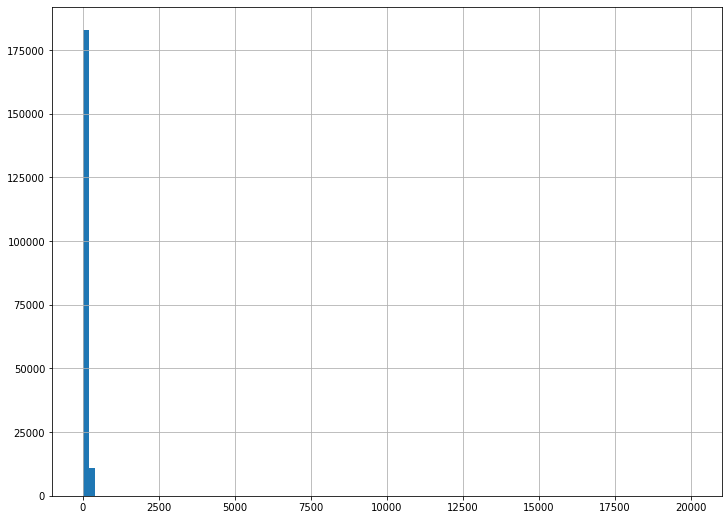

In [25]:
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

count    193845.000000
mean        110.338121
std          57.304278
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

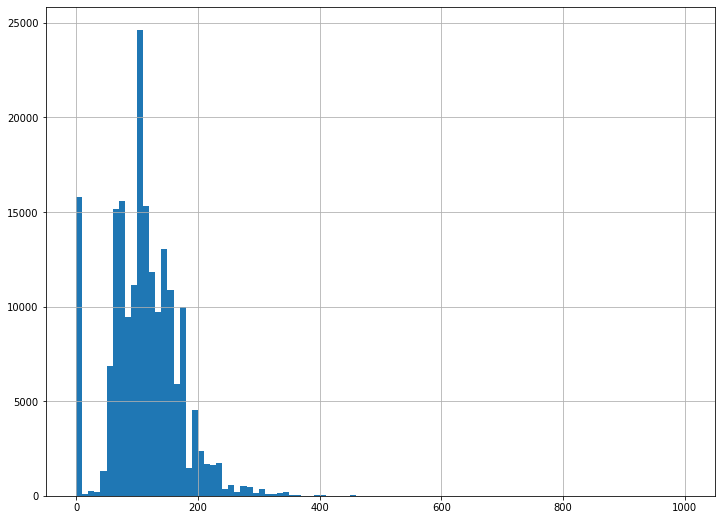

In [26]:

filtred_auto_df = filtred_auto_df.query('Power < 1001')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

Из данных и графика видно, что многие машины имеют мощность 0, уберем их

count    178144.000000
mean        119.800386
std          47.916850
min           1.000000
25%          83.000000
50%         114.000000
75%         146.000000
max         449.000000
Name: Power, dtype: float64

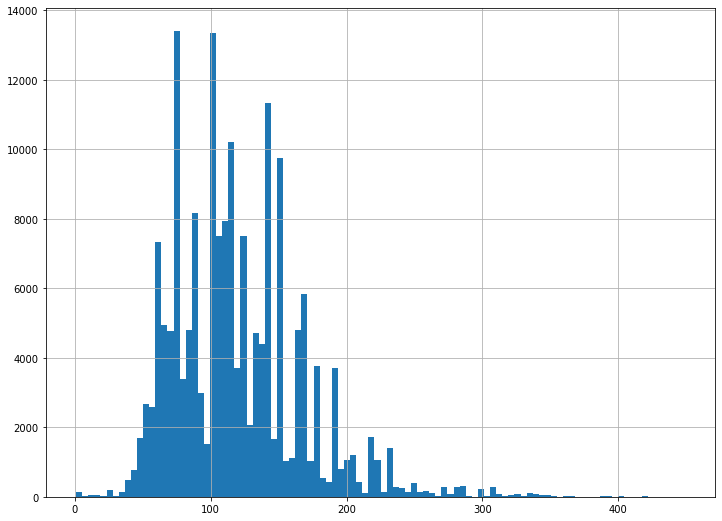

In [27]:
# Справа подобрали значение в 450 л.с.
filtred_auto_df = filtred_auto_df.query('0 < Power < 450')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

In [28]:
good_auto_df = filtred_auto_df
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178144 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       178144 non-null  object
 1   RegistrationYear  178144 non-null  int64 
 2   Gearbox           178144 non-null  object
 3   Power             178144 non-null  int64 
 4   Model             178144 non-null  object
 5   Kilometer         178144 non-null  int64 
 6   FuelType          178144 non-null  object
 7   Brand             178144 non-null  object
 8   NotRepaired       178144 non-null  object
 9   Price             178144 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.0+ MB


Далее нам нужно привести данные столбцов `Gearbox и NotRepaire` в булевый тип, чтобы было легче работать программе и быстрее все обрабатывать.

In [29]:
# Создадим столбец 'Is_manual_gearbox', где 1 - это manual, 0 - это auto
good_auto_df['Is_manual_gearbox'] = 0
good_auto_df.loc[good_auto_df['Gearbox'] == 'manual', 'Is_manual_gearbox'] = 1
display(good_auto_df['Is_manual_gearbox'].value_counts())
good_auto_df['Gearbox'].value_counts()

1    143491
0     34653
Name: Is_manual_gearbox, dtype: int64

manual    143491
auto       34653
Name: Gearbox, dtype: int64

In [30]:
# Создадим столбец 'Was_not_repaired', где 1 - это машина не ремонтировалась, 0 - машина с ремонтом
good_auto_df['Was_not_repaired'] = 0
good_auto_df.loc[good_auto_df['NotRepaired'] == 'yes', 'Was_not_repaired'] = 1
display(good_auto_df['Was_not_repaired'].value_counts())
good_auto_df['NotRepaired'].value_counts()

0    139318
1     38826
Name: Was_not_repaired, dtype: int64

no     139318
yes     38826
Name: NotRepaired, dtype: int64

Приведем датафрейм в порядок, удалим уже  не нужные столбцы, применим также downcast, чтобу уменьшить потребление памяти и ускорить работу фрейма

In [31]:
good_auto_df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
good_auto_df['Was_not_repaired'] = pd.to_numeric(good_auto_df['Was_not_repaired'], downcast='integer')
good_auto_df['Is_manual_gearbox'] = pd.to_numeric(good_auto_df['Is_manual_gearbox'], downcast='integer')
good_auto_df['RegistrationYear'] = pd.to_numeric(good_auto_df['RegistrationYear'], downcast='integer')
good_auto_df['Power'] = pd.to_numeric(good_auto_df['Power'], downcast='integer')
good_auto_df['Kilometer'] = pd.to_numeric(good_auto_df['Kilometer'], downcast='integer')
good_auto_df['Price'] = pd.to_numeric(good_auto_df['Price'], downcast='integer')
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178144 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        178144 non-null  object
 1   RegistrationYear   178144 non-null  int16 
 2   Power              178144 non-null  int16 
 3   Model              178144 non-null  object
 4   Kilometer          178144 non-null  int32 
 5   FuelType           178144 non-null  object
 6   Brand              178144 non-null  object
 7   Price              178144 non-null  int16 
 8   Is_manual_gearbox  178144 non-null  int8  
 9   Was_not_repaired   178144 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 8.8+ MB


In [32]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.2/43.3))

Уменьшение использования памяти на 76.44%


**Вывод**
1) Были проанализированы данные

2) Обработаны пропуски,аномалии и некорректные значения

3) Выбраны необходимые столбцы для обучения модели

4) Заменены категориальные признаки данных на численые

5) Обработали датафрейм и в итоге уменьшили потребление памяти на 76%

## Обучение моделей

Подготовим три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом OE. Название ordinal_features.

In [33]:
# Неизмененные принаки
original_features = good_auto_df.drop('Price', axis=1)

# Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

#Целевой признак
target = good_auto_df['Price']

In [34]:
#Обуч и тест выборка
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=1515)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### Линейная регрессия

In [35]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 1753.318205840232
CPU times: user 1min 29s, sys: 1min 12s, total: 2min 42s
Wall time: 2min 43s


In [36]:
%%time

# Попробуем с масштабируемыми признаками
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 12439051856967.633
CPU times: user 1min 36s, sys: 1min 11s, total: 2min 48s
Wall time: 2min 49s


In [38]:
%%time

# Попробуем с масштабируемыми признаками
regressor = LinearRegression()
scaller = RobustScaler()
pipeline = Pipeline([("robust_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2547381414.599694
CPU times: user 1min 29s, sys: 59 s, total: 2min 28s
Wall time: 2min 29s


**Вывод** Масштабмрование ухудшает модель

### DecissionTree регрессия

In [39]:
%%time

# Модель на признаках, закодированных по методу OHE


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

Grid scores on development set:

2015.823580 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
1888.306538 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
1742.694299 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
1664.347257 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
1593.144277 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
1535.780416 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
1485.521977 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
1447.570214 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

CPU times: user 1min 13s, sys: 8.51 s, total: 1min 21s
Wall time: 1min 22s


In [40]:
%%time

# Модель на признаках, закодированных по методу OE


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

Grid scores on development set:

2015.823580 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
1888.306538 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
1743.614248 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
1661.325240 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
1590.840620 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
1529.570350 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
1479.971651 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
1444.679559 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

CPU times: user 5.85 s, sys: 80.8 ms, total: 5.93 s
Wall time: 5.93 s


### Регрессия CatBoostRegressor

In [41]:
%%time

# Модель на данных, закодированных по методу OE

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}

Grid scores on development set:

1204.723625 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
1199.378860 for {'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}
1217.835293 for {'learning_rate': 0.8, 'random_state': 1515, 'verbose': False}

CPU times: user 4min 19s, sys: 5.58 s, total: 4min 25s
Wall time: 4min 39s


In [42]:
%%time

# Модель на оригинальных данных с указанием категорий


regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 100,
                              random_state=1515, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1233.9044111351527
CPU times: user 17.9 s, sys: 313 ms, total: 18.2 s
Wall time: 19.4 s


### Регрессия LGBM

In [43]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

Grid scores on development set:

1256.414290 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}
1208.121814 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 1515}
1197.064570 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

CPU times: user 4min 39s, sys: 0 ns, total: 4min 39s
Wall time: 4min 42s


### Предсказание на лучших параметрах

#### Линейная регрессия

In [44]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)


CPU times: user 20.5 s, sys: 4.91 s, total: 25.4 s
Wall time: 26.1 s


LinearRegression()

In [45]:
%%time

target_predict = model.predict(ohe_features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 91.5 ms, sys: 117 ms, total: 208 ms
Wall time: 219 ms


#### DecisionTree регрессия 

In [46]:
%%time

# Модель на принаках, закодированных по методу OHE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=1515) 
model.fit(ohe_features_train, target_train)

CPU times: user 4.52 s, sys: 213 ms, total: 4.74 s
Wall time: 4.8 s


DecisionTreeRegressor(max_depth=15, random_state=1515)

In [47]:
%%time
target_predict = model.predict(ohe_features_test)

CPU times: user 47.6 ms, sys: 57 ms, total: 105 ms
Wall time: 114 ms


In [48]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5 

In [49]:
%%time

# Модель на принаках, закодированных по методу OE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=1515) 
model.fit(ordinal_features_train, target_train)

CPU times: user 335 ms, sys: 6.14 ms, total: 341 ms
Wall time: 346 ms


DecisionTreeRegressor(max_depth=13, random_state=1515)

In [50]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 12.2 ms, sys: 195 µs, total: 12.4 ms
Wall time: 10.2 ms


In [51]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5  

#### CatBoost регрессия

In [52]:
%%time

# Модель на данных, закодированных по методу OE
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=1515, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

CPU times: user 17.5 s, sys: 348 ms, total: 17.9 s
Wall time: 18.7 s


In [53]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 45.5 ms, sys: 911 µs, total: 46.4 ms
Wall time: 45 ms


In [54]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [55]:
%%time

# Модель на оригинальных данных с указанием категорий
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 100, 
                          random_state=1551, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 4.2 s, sys: 72.5 ms, total: 4.27 s
Wall time: 4.48 s


In [56]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 43.1 ms, sys: 215 µs, total: 43.3 ms
Wall time: 41.5 ms


In [57]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

#### LGBM регрессия

In [58]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(ordinal_features_train, target_train)
target_predict = model.predict(ordinal_features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 7.23 s


In [59]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 477 ms, sys: 0 ns, total: 477 ms
Wall time: 414 ms


In [60]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

## Анализ моделей

Сформимруем таблицу дял вывода

In [62]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[162,
                                     81,
                                     6,
                                     265,
                                     18,
                                     279],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[25,
                                      5,
                                      0.3,
                                      18,
                                      4,
                                      7],
        'Время предсказания модели, сек':[0.2,
                                          0.11,
                                          0.12,
                                          0.046,
                                          0.043,
                                          0.47]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,1753.318206,162,1750.325448,25.0,0.200,0.682742,0.012000,0.215000,0.909742
DecisionTreeRegressor on OHE features,1447.570214,81,1362.321510,5.0,0.110,0.826948,0.060000,0.390909,1.277857
DecisionTreeRegressor on OE features,1444.679559,6,1370.122233,0.3,0.120,0.828602,1.000000,0.358333,2.186935
CatBoostRegressor on OE features,1199.378860,265,1186.193559,18.0,0.046,0.998070,0.016667,0.934783,1.949520
CatBoostRegressor on original features,1233.904411,18,1238.894454,4.0,0.043,0.970144,0.075000,1.000000,2.045144
LGBMRegressor,1197.064570,279,1205.798632,7.0,0.470,1.000000,0.042857,0.091489,1.134347


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей